In [81]:
import librosa

In [137]:
# import some libraries you maybe use
import torchvision # an useful library to help I/O (highly recommend). To install this, just do "pip install torchvision"
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
print(np.__version__)
print(torch.__version__)
print(torchvision.__version__)
import os
import visdom
import scipy
from utils.transform import transform
from utils.plot_cm import plot_cm
import sklearn
from importlib import reload 

1.17.4
1.0.1.post2
0.2.2


In [83]:
batch_size = 160

In [153]:
ROOT_DIR = './results'
TRAINING_NAME = 'resnet50_meldata_simpn'
OUTPUT_DIR = os.path.join(ROOT_DIR, TRAINING_NAME)
MODEL_PATH = os.path.join(OUTPUT_DIR, 'weight.pth')
ACC_MODEL_PATH = os.path.join(OUTPUT_DIR, 'weight_acc.pth')
RESULT_PATH = os.path.join(OUTPUT_DIR, 'result.csv')
NP_PATH =  os.path.join(OUTPUT_DIR, 'raw_result.npy')
LOG_PATH = os.path.join(OUTPUT_DIR, 'log')
FIG_PATH = os.path.join(OUTPUT_DIR, 'cm.png')
isPAD = False
isSIMPN = True

In [154]:
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
log = open(LOG_PATH, "w+")

# Data loading and preprocessing
In order to train the model with training data, the first step is to read the data from your folder, database, etc. The below is just an example.

In [155]:
from torchvision.datasets import ImageFolder, DatasetFolder
from torchvision.transforms import Compose, ToTensor, Grayscale, Resize, Normalize
from torch.utils.data import DataLoader
import os
# Define path to your dataset
dataset = "./melsimpndata" # the root folder
trainpath = os.path.join(dataset,"train") # train set
valpath = os.path.join(dataset,"val") # validation set
"""
def pad(raw):
    ex = np.zeros((22050,))
    ex[:len(raw)] = raw
    return ex

cut = lambda x: x[-11025:]
#cut_front = lambda x: x[:11025]
norm =  lambda x: (x.astype(np.float32) / (np.max(x)+1e-6))*0.5
spct = lambda x: scipy.signal.spectrogram(x ,fs= 10e3,mode='phase')[2] #overlap
tri = lambda x: [x, x, x]
totensor = lambda x: torch.Tensor(x)

tsfm = Compose([
        pad, # rescale to -1 to 1
        norm, # rescale to -1 to 1
        spct, # MFCC 
        tri,
        totensor
        ])

nploader = np.load
"""
torchloader = torch.load


In [156]:
traindata = DatasetFolder(root=trainpath, loader=torchloader, extensions=['pt'])
valdata = DatasetFolder(root=valpath, loader=torchloader, extensions=['pt'])

# Create a loader
trainloader = DataLoader(traindata,batch_size=batch_size,shuffle=True, pin_memory=True, num_workers=6)
valloader = DataLoader(valdata,batch_size=batch_size,shuffle=True,  pin_memory=True, num_workers=6)

In [157]:
print(traindata.classes) # show all classes
print(traindata.class_to_idx) # show the mapping from class to index.

['Frog1', 'Frog2', 'Frog3', 'Grylloidea1', 'Grylloidea2', 'Tettigonioidea1', 'Tettigonioidea2', 'drums_FloorTom', 'drums_HiHat', 'drums_Kick', 'drums_MidTom', 'drums_Ride', 'drums_Rim', 'drums_SmallTom', 'drums_Snare', 'guitar_3rd_fret', 'guitar_7th_fret', 'guitar_9th_fret', 'guitar_chord1', 'guitar_chord2']
{'Frog1': 0, 'Frog2': 1, 'Frog3': 2, 'Grylloidea1': 3, 'Grylloidea2': 4, 'Tettigonioidea1': 5, 'Tettigonioidea2': 6, 'drums_FloorTom': 7, 'drums_HiHat': 8, 'drums_Kick': 9, 'drums_MidTom': 10, 'drums_Ride': 11, 'drums_Rim': 12, 'drums_SmallTom': 13, 'drums_Snare': 14, 'guitar_3rd_fret': 15, 'guitar_7th_fret': 16, 'guitar_9th_fret': 17, 'guitar_chord1': 18, 'guitar_chord2': 19}


In [158]:
idx_to_class = {val: key for key, val in traindata.class_to_idx.items()} # build an inverse mapping for later use
print(idx_to_class)

{0: 'Frog1', 1: 'Frog2', 2: 'Frog3', 3: 'Grylloidea1', 4: 'Grylloidea2', 5: 'Tettigonioidea1', 6: 'Tettigonioidea2', 7: 'drums_FloorTom', 8: 'drums_HiHat', 9: 'drums_Kick', 10: 'drums_MidTom', 11: 'drums_Ride', 12: 'drums_Rim', 13: 'drums_SmallTom', 14: 'drums_Snare', 15: 'guitar_3rd_fret', 16: 'guitar_7th_fret', 17: 'guitar_9th_fret', 18: 'guitar_chord1', 19: 'guitar_chord2'}


In [159]:
correct_idx2class = {9: 'Frog1', 10: 'Frog2', 19: 'Frog3', 3: 'Grylloidea1', 14: 'Grylloidea2', 0: 'Tettigonioidea1', 1: 'Tettigonioidea2', 11: 'drums_FloorTom', 5: 'drums_HiHat', 6: 'drums_Kick', 4: 'drums_MidTom', 16: 'drums_Ride', 13: 'drums_Rim', 7: 'drums_SmallTom', 2: 'drums_Snare', 15: 'guitar_3rd_fret', 12: 'guitar_7th_fret', 18: 'guitar_9th_fret', 17: 'guitar_chord1', 8: 'guitar_chord2'}
#print(correct_idx2class)

In [160]:
correct_class2idx = {val: key for key, val in correct_idx2class.items()}
#print(correct_class2idx)

In [161]:
corrected_idx2idx = {val: correct_class2idx[key] for key, val in traindata.class_to_idx.items()}
print(corrected_idx2idx)

{0: 9, 1: 10, 2: 19, 3: 3, 4: 14, 5: 0, 6: 1, 7: 11, 8: 5, 9: 6, 10: 4, 11: 16, 12: 13, 13: 7, 14: 2, 15: 15, 16: 12, 17: 18, 18: 17, 19: 8}


# Build an example network
If you're unfamiliar with this part, please see the HW1 tutorial.

In [162]:
import utils.resnet as resnet
model =resnet.resnet50(num_classes= len(traindata.classes))

In [163]:
#net = Net(num_classes=len(traindata.classes)) # initialize your network
net = model
# Whether to use GPU or not?
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
else: 
    device = 'cpu'
print("use",device,"now!")
net.to(device)
optimizer = optim.Adam(net.parameters(), lr=0.01) # setup your optimizer
#optimizer = optim.SGD(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss() # setup your criterion
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9) #0.1->0.8

use cuda now!


# Train the model with the data

In [164]:
def save_model(model,filename):
    state = model.state_dict()
    for key in state: state[key] = state[key].clone().cpu()
    torch.save(state, filename)
#save_model(net,"weight.pth")


In [165]:
import utils.visdoms as visdoms
plotter = visdoms.VisdomLinePlotter(env_name=TRAINING_NAME)

Setting up a new session...


In [ ]:
net.train()
num_epoch = 120
best_loss = 1e8
best_acc = 0
train_losses = visdoms.AverageMeter()
val_losses = visdoms.AverageMeter()
for epoch in range(num_epoch):
    #net.train()
    for batch_idx, (data, target) in enumerate(trainloader):
        #print(data.shape,target)
        data = data.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        train_losses.update(loss.data.cpu().numpy(), target.size(0))
        loss.backward()
        optimizer.step()
        print('.',  end='')
    scheduler.step()
        
        
    plotter.plot('loss', 'train', 'Class Loss', epoch, train_losses.avg)
    
    net.eval()
    correct = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(valloader):
            data = data.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)
            output = net(data)
            val_loss = criterion(output, target)
            val_losses.update(val_loss.data.cpu().numpy(), target.size(0))
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            print('.',  end='')
        acc = correct.item() / len(valloader.dataset)
        print("Val Acc: %f"%(acc))

        plotter.plot('loss', 'val', 'Class Loss', epoch, val_losses.avg)
        plotter.plot('acc', 'val', 'Class Accuracy', epoch, acc)
            
        print('epoch %d, lr %.6f, loss: %.4f, val_loss: %.4f' %(epoch+1, optimizer.param_groups[0]['lr'], loss.item(), val_loss.item()))
        if val_loss.item() < best_loss:
            best_loss = val_loss.item()
            save_model(net, MODEL_PATH)
        if acc > best_acc:
            best_acc = acc
            save_model(net, ACC_MODEL_PATH)
    
    

...................................................................................Val Acc: 0.236231
epoch 1, lr 0.010000, loss: 0.9579, val_loss: 4.0943
...................................................................................Val Acc: 0.377797
epoch 2, lr 0.010000, loss: 1.6136, val_loss: 1.8036
...................................................................................Val Acc: 0.526678
epoch 3, lr 0.010000, loss: 1.0316, val_loss: 1.3303
...................................................................................Val Acc: 0.672978
epoch 4, lr 0.010000, loss: 0.6468, val_loss: 0.9795
...................................................................................Val Acc: 0.765060
epoch 5, lr 0.010000, loss: 0.6669, val_loss: 0.7811
...................................................................................Val Acc: 0.808950
epoch 6, lr 0.010000, loss: 0.4236, val_loss: 0.6289
............................................................................

In [ ]:

from matplotlib import pyplot as plt
plt.plot(train_losses.arr)
plt.plot(val_losses.arr)
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

# Load model

In [ ]:
def load_model(model,filename):
    model.load_state_dict(torch.load(filename))
    return model
#net = Net(num_classes=len(traindata.classes)) # initialize your network
net = model
net = load_model(net, MODEL_PATH)
# Whether to use GPU or not?
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
else: 
    device = 'cpu'
print("use",device,"now!")
net.to(device)

# Evaluate on validation data

In [179]:
net.eval()
correct = 0
vresult = []
vtarget = []
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(valloader):
        #print(type(data))
        data = data.to(device)
        target = target.to(device)
        output = net(data)
        pred = output.data.max(1, keepdim=True)[1]
        
        vresult = vresult + list(pred.cpu().numpy().ravel())
        vtarget = vtarget + list(target.cpu().numpy().ravel())
        
        correct += pred.eq(target.data.view_as(pred)).sum()
    acc = correct.item() / len(valloader.dataset)
print("Validation Classification Accuracy: %f"%(acc))
log.write("Validation Classification Accuracy: %f"%(acc))

Validation Classification Accuracy: 0.969019


44

In [180]:
cm = sklearn.metrics.confusion_matrix(vresult, vtarget)

In [177]:
from utils.plot_cm import plot_cm
reload(utils.plot_cm)

<module 'utils.plot_cm' from '/home/tsai/workspace/DSP_FINAL/utils/plot_cm.py'>

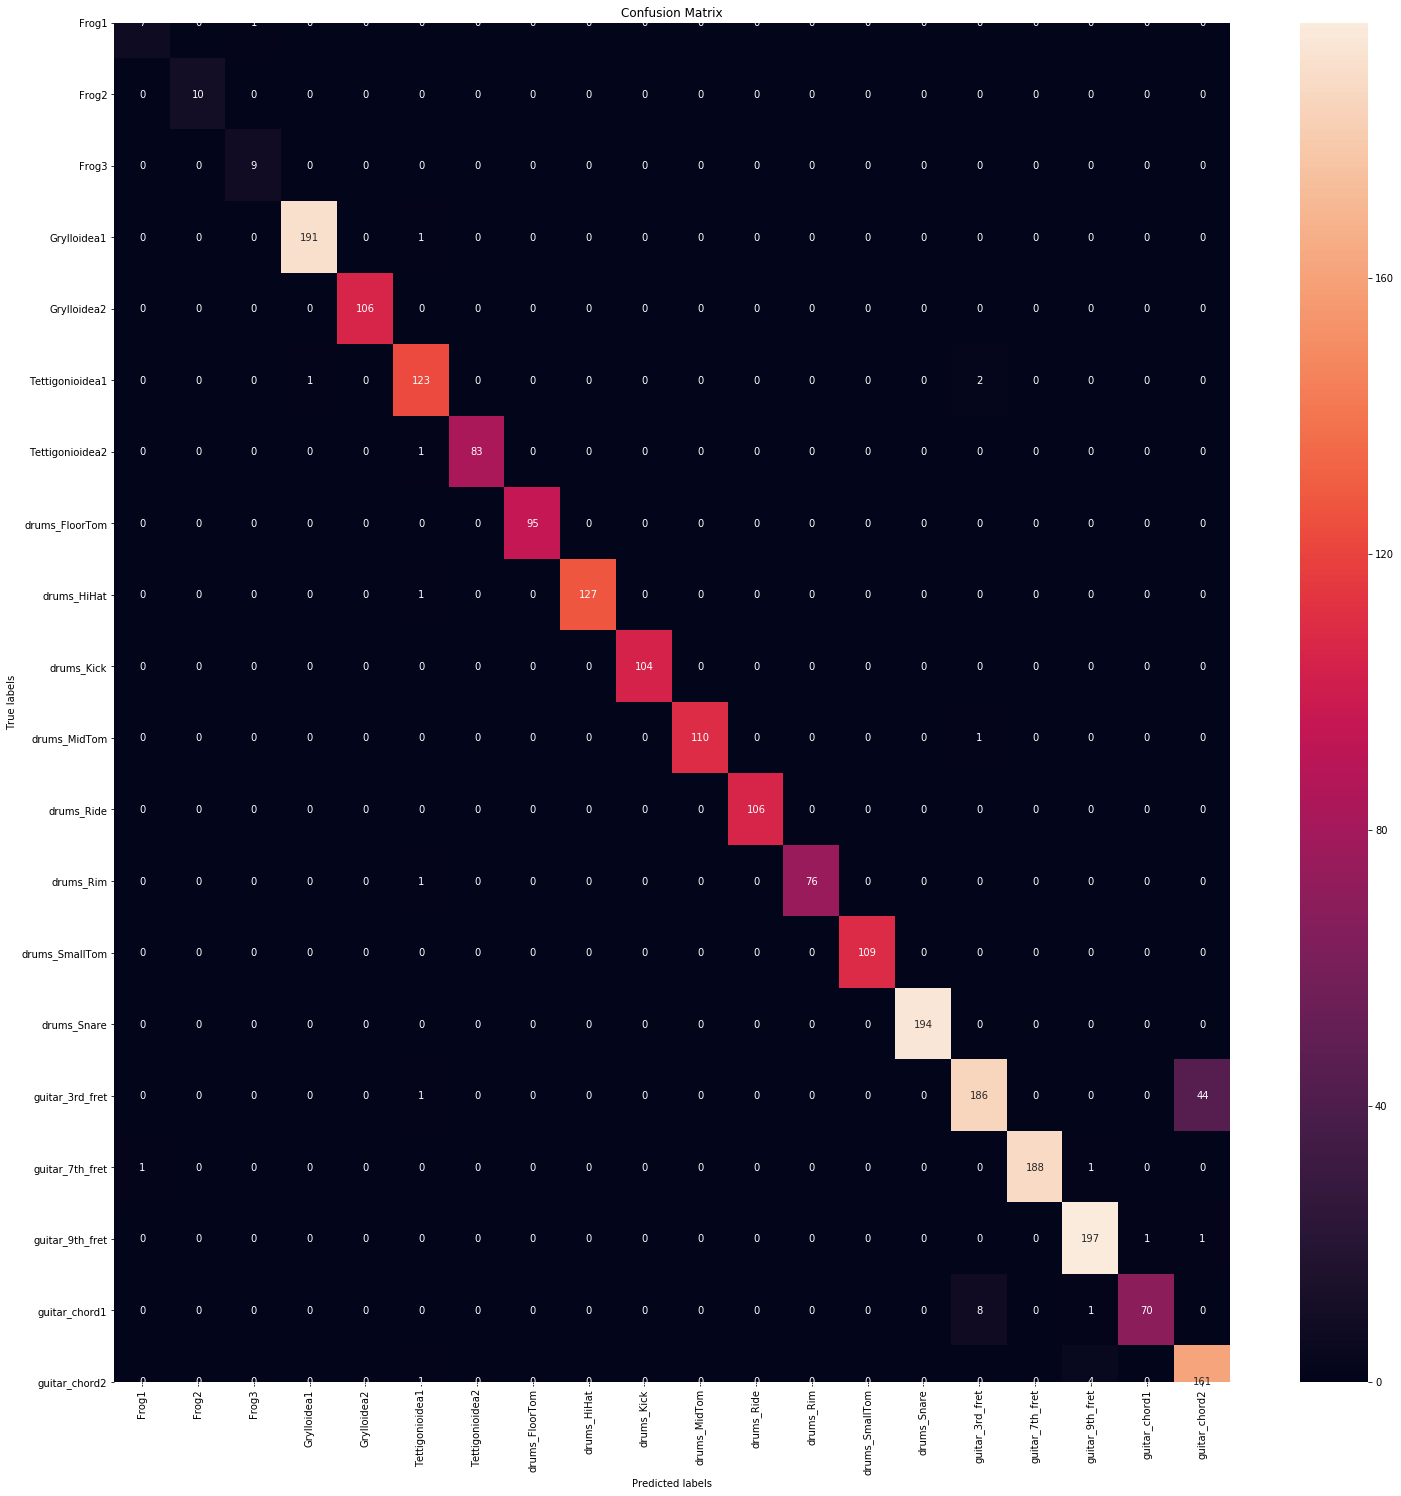

In [178]:
plot_cm(cm ,FIG_PATH, traindata.classes)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt     

f = plt.figure(figsize=(25, 25))
ax= f.add_subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='d'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(traindata.classes, rotation='vertical'); ax.yaxis.set_ticklabels(traindata.classes, rotation='horizontal');
plt.savefig(FIG_PATH)

# Loading Testing Data

In [ ]:
test_data = np.load('./data/test.npy', allow_pickle=True)
print(len(test_data))

In [ ]:
t_spec = []
import utils.transform as transform
reload(transform)
for t in test_data:
    """
    test = cut(t)
    test = norm(test)
    test = spct(test) 
    test = tri(test)
    test = totensor(test)
    """
    test = transform.transform(t, padding=isPAD, simplenorm=isSIMPN)
    t_spec.append(test)

In [ ]:
print(type(test))
print(type(test.data))

In [ ]:
tensor_x = torch.stack(t_spec)

In [ ]:
tensor_x[0][0][0][0]

In [ ]:
test_dataset = torch.utils.data.TensorDataset(tensor_x) # create your datset
test_dataloader = torch.utils.data.DataLoader(test_dataset) # create your dataloader

In [ ]:
net.eval()
result = []
raw_result = []
with torch.no_grad():
    for batch_idx, (data, ) in enumerate(test_dataloader):  
        data = data.to(device)
        #target = target.to(device)
        output = net(data)
        pred = output.data.max(1, keepdim=True)[1]
        #correct += pred.eq(target.data.view_as(pred)).sum()
        result = result + list(pred.cpu().numpy().ravel())
        raw_result.append(list(output.cpu().numpy().ravel()))
    #acc = correct.item() / len(valloader.dataset)
#print("Validation Classification Accuracy: %f"%(acc))

In [ ]:
output

In [ ]:
np.save(NP_PATH, np.asarray(raw_result))

In [ ]:
result = [corrected_idx2idx[idx] for idx in result]

In [ ]:
df_dict = {'id': list(range(0 ,len(test_data))), 'category':result}

In [ ]:
import pandas as pd
df = pd.DataFrame(df_dict)

In [ ]:
df.head()

In [ ]:
df.to_csv(RESULT_PATH, index=False)